In [3]:
## extracting data set and save on two files that latter would be
### used for data analysies and Ml models


In [78]:
import os
import glob
import numpy as np

DATA_DIR = "./quadrature_data_4qubits"
OUT_X = "dataset_X.txt"
OUT_Y = "dataset_y.txt"


def parse_complex_string(s: str) -> complex:
    """
    Convert a string like '(1.23+4.56j)' into a Python complex number.
    Parentheses are removed if present.
    """
    s = s.strip()
    if s.startswith("(") and s.endswith(")"):
        s = s[1:-1]
    return complex(s)


def load_single_file(file_path: str) -> np.ndarray:
    """
    Load a file such as '0000.txt'.
    Returns a numpy array of shape (4, 1000):
        axis 0 → qubit index (1..4)
        axis 1 → sample index (0..999)
    """
    with open(file_path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]

    if len(lines) != 4:
        raise ValueError(f"{file_path}: Expected 4 lines, found {len(lines)}.")

    qubit_arrays = []
    for i, line in enumerate(lines):
        tokens = line.split()
        complex_vals = [parse_complex_string(tok) for tok in tokens]
        arr = np.array(complex_vals, dtype=np.complex128)

        if arr.size != 1000:
            raise ValueError(
                f"{file_path}, line {i+1}: Expected 1000 values, found {arr.size}."
            )

        qubit_arrays.append(arr)

    return np.stack(qubit_arrays, axis=0)  # shape (4, 1000)


def bits_from_filename(filename: str) -> np.ndarray:
    """
    Convert a filename like '0110.txt' into a 4-bit label [q1, q2, q3, q4].
    Bits are read from right to left:
        rightmost bit → qubit1
        leftmost bit → qubit4
    """
    base = os.path.splitext(os.path.basename(filename))[0]  # '0110'
    if len(base) != 4 or any(c not in "01" for c in base):
        raise ValueError(f"File name must be a 4-bit string, got '{base}'")

    # Reverse bit order: LSB = qubit1
    bits = [int(b) for b in base[::-1]]
    return np.array(bits, dtype=int)


def build_datasets():
    """
    Build dataset_X.txt and dataset_y.txt
    dataset_X: 16000 × 4 (complex values)
    dataset_y: 16000 × 4 (bit labels)
    """
    pattern = os.path.join(DATA_DIR, "[01][01][01][01].txt")
    file_paths = glob.glob(pattern)

    if len(file_paths) != 16:
        print("WARNING: Expected 16 files, found:", len(file_paths))

    # Sort files from 0000 → 1111
    file_paths = sorted(
        file_paths,
        key=lambda fp: int(os.path.splitext(os.path.basename(fp))[0], 2),
    )

    all_X_rows = []
    all_y_rows = []

    for fp in file_paths:
        base = os.path.splitext(os.path.basename(fp))[0]
        print(f"Processing file: {base}.txt")

        data_4x1000 = load_single_file(fp)  # shape (4,1000)
        num_qubits, num_samples = data_4x1000.shape
        assert num_qubits == 4

        # Label vector [q1 q2 q3 q4]
        label_bits = bits_from_filename(fp)

        # Prepare blocks of data and labels
        X_block = data_4x1000.T          # shape (1000,4)
        y_block = np.tile(label_bits, (num_samples, 1))  # shape (1000,4)

        all_X_rows.append(X_block)
        all_y_rows.append(y_block)

    # Concatenate all 16 files → 16000 rows
    X = np.vstack(all_X_rows)
    y = np.vstack(all_y_rows)

    print("Final X shape:", X.shape)
    print("Final y shape:", y.shape)

    # Write complex data WITHOUT parentheses
    with open(OUT_X, "w") as f:
        for row in X:
            # Format as: +1.23e+00+4.56e+00j  -3.21e-01+8.76e-01j  ...
            line = " ".join(f"{z.real:+.9e}{z.imag:+.9e}j" for z in row)
            f.write(line + "\n")

    # Write labels as integers
    np.savetxt(OUT_Y, y, fmt="%d")

    print(f"Files '{OUT_X}' and '{OUT_Y}' successfully written.")


if __name__ == "__main__":
    build_datasets()


Processing file: 0000.txt
Processing file: 0001.txt
Processing file: 0010.txt
Processing file: 0011.txt
Processing file: 0100.txt
Processing file: 0101.txt
Processing file: 0110.txt
Processing file: 0111.txt
Processing file: 1000.txt
Processing file: 1001.txt
Processing file: 1010.txt
Processing file: 1011.txt
Processing file: 1100.txt
Processing file: 1101.txt
Processing file: 1110.txt
Processing file: 1111.txt
Final X shape: (16000, 4)
Final y shape: (16000, 4)
Files 'dataset_X.txt' and 'dataset_y.txt' successfully written.


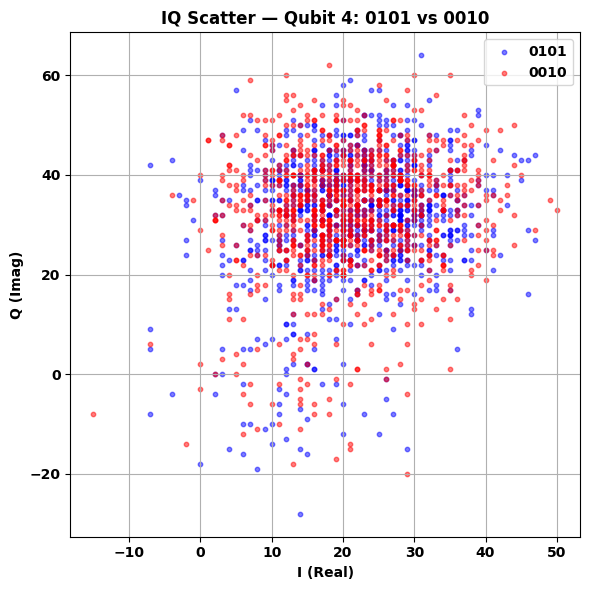

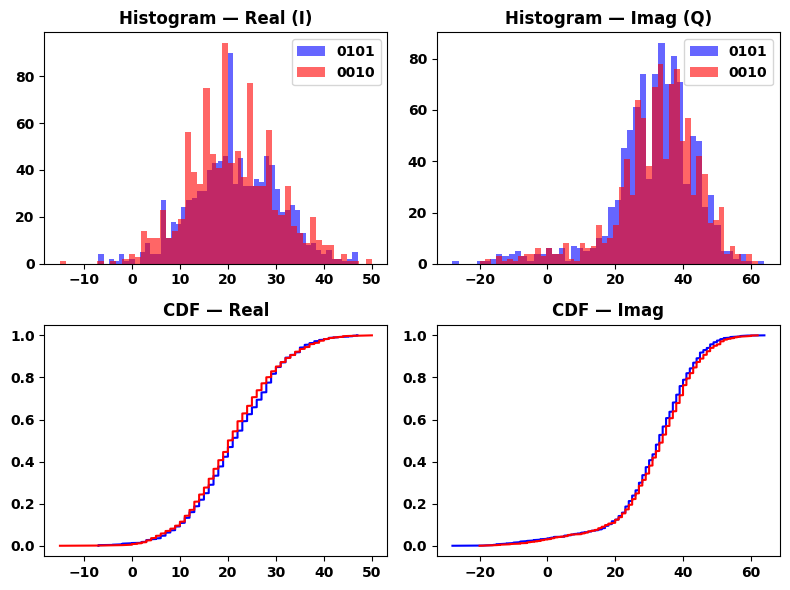

In [80]:
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------------------------------------
# Load dataset
# -----------------------------------------------------------
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    """
    Load complex data matrix X (16000×4) and label matrix y (16000×4).
    """
    X = np.loadtxt(X_path, dtype=complex)
    y = np.loadtxt(y_path, dtype=int)
    return X, y


# -----------------------------------------------------------
# Convert state string "Q4 Q3 Q2 Q1" → dataset label [q1 q2 q3 q4]
# -----------------------------------------------------------
def state_to_label(state_str):
    """
    Convert a 4-bit string Q4 Q3 Q2 Q1 into dataset label [q1, q2, q3, q4].

    Examples:
        "0001" → (Q4=0,Q3=0,Q2=0,Q1=1) → [1,0,0,0]
        "0010" → (Q4=0,Q3=0,Q2=1,Q1=0) → [0,1,0,0]
        "0100" → [0,0,1,0]
        "1000" → [0,0,0,1]
    """
    if len(state_str) != 4 or any(c not in "01" for c in state_str):
        raise ValueError("State must be 4 bits, e.g. '0100'.")

    # state_str = Q4 Q3 Q2 Q1
    Q4, Q3, Q2, Q1 = (int(b) for b in state_str)

    # dataset labels are [q1, q2, q3, q4] = [Q1, Q2, Q3, Q4]
    return np.array([Q1, Q2, Q3, Q4], dtype=int)


# -----------------------------------------------------------
# Extract complex samples for one qubit for a given state
# -----------------------------------------------------------
def get_qubit_samples(X, y, state_str, qubit_index):
    """
    Return all complex samples for the selected qubit (0..3)
    corresponding to the desired state string (e.g., '1000').
    """
    target_label = state_to_label(state_str)
    mask = np.all(y == target_label, axis=1)
    samples = X[mask, qubit_index]
    return samples


# -----------------------------------------------------------
# Plot IQ scatter comparison
# -----------------------------------------------------------
def plot_compare_iq(samples1, samples2, state1, state2, qubit_index):
    I1, Q1 = samples1.real, samples1.imag
    I2, Q2 = samples2.real, samples2.imag

    plt.figure(figsize=(6, 6))
    plt.scatter(I1, Q1, s=10, alpha=0.5, color="blue", label=state1)
    plt.scatter(I2, Q2, s=10, alpha=0.5, color="red",  label=state2)

    plt.xlabel("I (Real)")
    plt.ylabel("Q (Imag)")
    plt.title(f"IQ Scatter — Qubit {qubit_index+1}: {state1} vs {state2}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------
# Plot Histograms + CDF
# -----------------------------------------------------------
def plot_compare_histograms(samples1, samples2, state1, state2, qubit_index):
    I1, Q1 = samples1.real, samples1.imag
    I2, Q2 = samples2.real, samples2.imag

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    # Histogram: Real part
    axes[0,0].hist(I1, bins=50, alpha=0.6, color="blue", label=state1)
    axes[0,0].hist(I2, bins=50, alpha=0.6, color="red",  label=state2)
    axes[0,0].set_title("Histogram — Real (I)")
    axes[0,0].legend()

    # Histogram: Imag part
    axes[0,1].hist(Q1, bins=50, alpha=0.6, color="blue", label=state1)
    axes[0,1].hist(Q2, bins=50, alpha=0.6, color="red",  label=state2)
    axes[0,1].set_title("Histogram — Imag (Q)")
    axes[0,1].legend()

    # CDF — Real
    axes[1,0].plot(sorted(I1), np.linspace(0,1,len(I1)), color="blue")
    axes[1,0].plot(sorted(I2), np.linspace(0,1,len(I2)), color="red")
    axes[1,0].set_title("CDF — Real")

    # CDF — Imag
    axes[1,1].plot(sorted(Q1), np.linspace(0,1,len(Q1)), color="blue")
    axes[1,1].plot(sorted(Q2), np.linspace(0,1,len(Q2)), color="red")
    axes[1,1].set_title("CDF — Imag")

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------
# Example Usage
# -----------------------------------------------------------

# Load dataset
X, y = load_dataset()

# Choose qubit (0 → qubit1, ..., 3 → qubit4)
qubit_index = 3      # example: qubit4

# Choose any two states (Q4 Q3 Q2 Q1)
state_A = "0101"     # qubit1 = 1
state_B = "0010"     # qubit2 = 1

samples_A = get_qubit_samples(X, y, state_A, qubit_index)
samples_B = get_qubit_samples(X, y, state_B, qubit_index)

plot_compare_iq(samples_A, samples_B, state_A, state_B, qubit_index)
plot_compare_histograms(samples_A, samples_B, state_A, state_B, qubit_index)


In [ ]:
### Gaussian Covariance Ellipse Plotting

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# -------------------------------------------
# Compute mean and covariance for (I,Q)
# -------------------------------------------
def compute_gaussian_params(samples):
    """
    samples: complex vector (n,)
    returns: mean (2,), covariance matrix (2x2)
    """
    I = samples.real
    Q = samples.imag

    mean = np.array([np.mean(I), np.mean(Q)])
    cov = np.cov(I, Q)

    return mean, cov


# -------------------------------------------
# Draw Gaussian ellipse from mean + covariance
# -------------------------------------------
def draw_ellipse(ax, mean, cov, color, label, n_std=2.0):
    """
    Draws an ellipse corresponding to n_std standard deviations.
    """
    # eigenvalues, eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # compute ellipse parameters
    width, height = 2 * n_std * np.sqrt(vals)  # radii = sqrt(lambda)
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))

    # create ellipse patch
    ell = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        edgecolor=color,
        facecolor="none",
        lw=2,
        label=label
    )
    ax.add_patch(ell)


# -------------------------------------------
# Main function: plot scatter + ellipses
# -------------------------------------------
def plot_gaussian_ellipses(samples1, samples2, 
                           state1, state2, qubit_index):
    """
    Draw scatter plots + covariance ellipses for two states.
    """
    I1, Q1 = samples1.real, samples1.imag
    I2, Q2 = samples2.real, samples2.imag

    # compute Gaussian parameters
    mean1, cov1 = compute_gaussian_params(samples1)
    mean2, cov2 = compute_gaussian_params(samples2)

    # setup plot
    fig, ax = plt.subplots(figsize=(7,7))

    # scatter points
    ax.scatter(I1, Q1, s=10, alpha=0.3, color="blue", label=f"{state1} samples")
    ax.scatter(I2, Q2, s=10, alpha=0.3, color="red",  label=f"{state2} samples")

    # draw Gaussian ellipses
    draw_ellipse(ax, mean1, cov1, color="blue", label=f"{state1} ellipse")
    draw_ellipse(ax, mean2, cov2, color="red",  label=f"{state2} ellipse")

    # mark means
    ax.scatter(mean1[0], mean1[1], color="blue", marker="x", s=120)
    ax.scatter(mean2[0], mean2[1], color="red", marker="x", s=120)

    ax.set_title(f"Gaussian Ellipses — Qubit {qubit_index+1}: {state1} vs {state2}")
    ax.set_xlabel("I (Real)")
    ax.set_ylabel("Q (Imag)")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


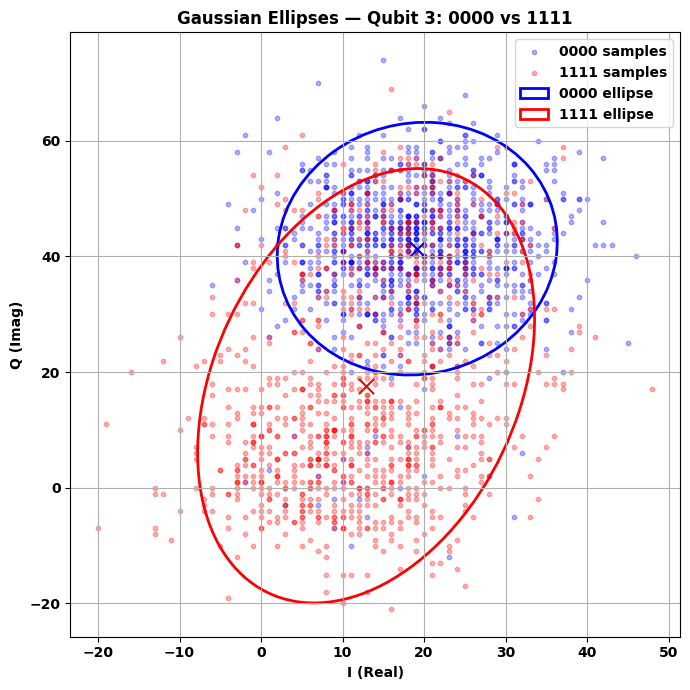

In [82]:
X, y = load_dataset()
qubit_index = 2      # example: qubit1

state_A = "0000"
state_B = "1111"

samples_A = get_qubit_samples(X, y, state_A, qubit_index)
samples_B = get_qubit_samples(X, y, state_B, qubit_index)

plot_gaussian_ellipses(samples_A, samples_B, state_A, state_B, qubit_index)


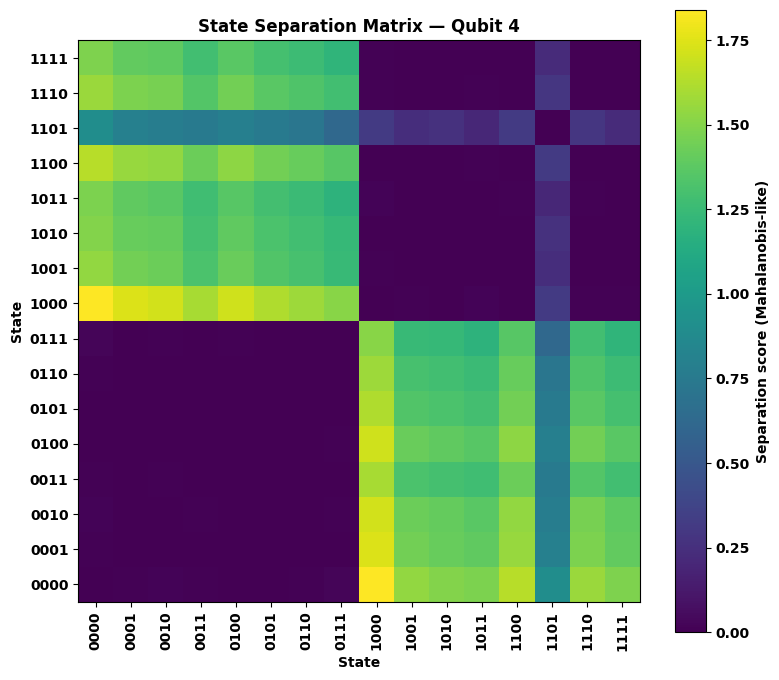

Most difficult pair for qubit 4 : ('0001', '0100') score = 0.00031095312647777686


In [83]:
# -----------------------------------------------------------
# NEW: separation metric (Mahalanobis/Fisher-like)
# -----------------------------------------------------------
def separation_score(samples1, samples2, eps=1e-6):
    """
    Compute a scalar separation score between two Gaussian-like clouds.
    We use:
        d^2 = (mu1 - mu2)^T (Sigma1 + Sigma2)^(-1) (mu1 - mu2)
    Larger d^2 => better separation.
    """
    mean1, cov1 = compute_gaussian_params(samples1)
    mean2, cov2 = compute_gaussian_params(samples2)

    diff = mean1 - mean2
    Sw = cov1 + cov2  # pooled within-class scatter

    # regularize a bit to avoid singular matrix
    Sw_reg = Sw + eps * np.eye(2)

    inv_Sw = np.linalg.inv(Sw_reg)
    d2 = float(diff.T @ inv_Sw @ diff)
    return d2


# -----------------------------------------------------------
# Build 16x16 separation matrix for a single qubit
# -----------------------------------------------------------
def build_separation_matrix_for_qubit(X, y, qubit_index):
    """
    Returns:
        states: list of 16 bit-strings "0000".. "1111"
        S:      16x16 matrix, S[i,j] = separation score between states[i], states[j]
    """
    states = [format(i, "04b") for i in range(16)]
    n = len(states)
    S = np.zeros((n, n), dtype=float)

    # pre-load samples for each state for speed
    samples_dict = {
        s: get_qubit_samples(X, y, s, qubit_index) for s in states
    }

    for i in range(n):
        for j in range(i+1, n):
            s1, s2 = states[i], states[j]
            samp1 = samples_dict[s1]
            samp2 = samples_dict[s2]

            # if any state has no samples (should not happen), skip
            if len(samp1) == 0 or len(samp2) == 0:
                score = 0.0
            else:
                score = separation_score(samp1, samp2)

            S[i, j] = S[j, i] = score

    return states, S


# -----------------------------------------------------------
# Plot heatmap for a given qubit
# -----------------------------------------------------------
def plot_separation_heatmap(states, S, qubit_index):
    """
    Plot a 16x16 heatmap of separation scores for the selected qubit.
    """
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(S, origin="lower", cmap="viridis")

    ax.set_xticks(range(len(states)))
    ax.set_yticks(range(len(states)))
    ax.set_xticklabels(states, rotation=90)
    ax.set_yticklabels(states)

    ax.set_title(f"State Separation Matrix — Qubit {qubit_index+1}")
    ax.set_xlabel("State")
    ax.set_ylabel("State")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Separation score (Mahalanobis-like)")

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------
# Example usage for qubit 1
# -----------------------------------------------------------
if __name__ == "__main__":
    X, y = load_dataset()

    qubit_index = 3  # 0..3 for qubits 1..4

    states, S = build_separation_matrix_for_qubit(X, y, qubit_index)
    plot_separation_heatmap(states, S, qubit_index)

    # Also print the most difficult pair (minimum non-zero separation)
    n = len(states)
    min_score = np.inf
    min_pair = None
    for i in range(n):
        for j in range(i+1, n):
            if S[i, j] < min_score and S[i, j] > 0:
                min_score = S[i, j]
                min_pair = (states[i], states[j])

    print("Most difficult pair for qubit", qubit_index+1, ":", min_pair, "score =", min_score)


In [94]:
## lets examine fidelity and separation score for different qubits
import numpy as np
import matplotlib.pyplot as plt


def project_to_optimal_axis(samples1, samples2, eps=1e-6):
    """
    Compute Fisher/LDA optimal axis w and project both classes onto it.
    Returns:
        u1, u2, w
    """
    mean1, cov1 = compute_gaussian_params(samples1)
    mean2, cov2 = compute_gaussian_params(samples2)

    Sw = cov1 + cov2 + eps * np.eye(2)   # pooled covariance + reg

    # w ∝ Sw^{-1} (mu2 - mu1)
    diff = mean2 - mean1
    w = np.linalg.solve(Sw, diff)

    # normalize w (not strictly necessary but nice)
    w = w / np.linalg.norm(w)

    # project (I,Q) onto w
    I1, Q1 = samples1.real, samples1.imag
    I2, Q2 = samples2.real, samples2.imag

    u1 = w[0] * I1 + w[1] * Q1
    u2 = w[0] * I2 + w[1] * Q2

    return u1, u2, w


def compute_readout_fidelity(samples1, samples2, n_thresh=400):
    """
    Empirically compute single-shot readout fidelity between two states.

    Steps:
    1) Project onto optimal Fisher axis.
    2) Scan several thresholds along that axis.
    3) Choose threshold that maximizes mean accuracy on both classes.
    """
    u1, u2, w = project_to_optimal_axis(samples1, samples2)

    # decide orientation: we want class2 to be "larger" on average
    if np.mean(u1) > np.mean(u2):
        u1, u2 = u2, u1   # swap so that mean(u2) > mean(u1)

    # scan thresholds between min and max of all projections
    all_u = np.concatenate([u1, u2])
    t_min, t_max = all_u.min(), all_u.max()
    thresholds = np.linspace(t_min, t_max, n_thresh)

    best_acc = 0.0
    best_t = thresholds[0]

    # true labels: class1 = 0, class2 = 1
    y1 = np.zeros_like(u1, dtype=int)
    y2 = np.ones_like(u2, dtype=int)

    for t in thresholds:
        # rule: u < t → class1, u >= t → class2
        pred1 = (u1 >= t).astype(int)
        pred2 = (u2 >= t).astype(int)

        acc1 = np.mean(pred1 == y1)
        acc2 = np.mean(pred2 == y2)
        acc_mean = 0.5 * (acc1 + acc2)

        if acc_mean > best_acc:
            best_acc = acc_mean
            best_t = t

    fidelity = best_acc
    return fidelity, best_t, w


In [95]:
X, y = load_dataset()

qubit_index = 0       # qubit 1
state_A = "0000"
state_B = "1111"

samples_A = get_qubit_samples(X, y, state_A, qubit_index)
samples_B = get_qubit_samples(X, y, state_B, qubit_index)

F, t_opt, w = compute_readout_fidelity(samples_A, samples_B)

print(f"Readout fidelity for qubit {qubit_index+1}, states {state_A} vs {state_B}: {F:.4f}")


Readout fidelity for qubit 1, states 0000 vs 1111: 0.7200


In [96]:
### Fidelity 16×16 Matrix for all state pairs
def build_fidelity_matrix_for_qubit(X, y, qubit_index):
    states = [format(i, "04b") for i in range(16)]
    n = len(states)
    F_mat = np.zeros((n, n), dtype=float)

    samples_dict = {s: get_qubit_samples(X, y, s, qubit_index) for s in states}

    for i in range(n):
        for j in range(i+1, n):
            s1, s2 = states[i], states[j]
            samp1 = samples_dict[s1]
            samp2 = samples_dict[s2]

            if len(samp1) == 0 or len(samp2) == 0:
                F = 0.5   # no info → random
            else:
                F, _, _ = compute_readout_fidelity(samp1, samp2)

            F_mat[i, j] = F_mat[j, i] = F

    # diagonal = perfect fidelity with itself
    np.fill_diagonal(F_mat, 1.0)

    return states, F_mat


def plot_fidelity_heatmap(states, F_mat, qubit_index):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(F_mat, origin="lower", vmin=0.5, vmax=1.0, cmap="viridis")

    ax.set_xticks(range(len(states)))
    ax.set_yticks(range(len(states)))
    ax.set_xticklabels(states, rotation=90)
    ax.set_yticklabels(states)

    ax.set_title(f"Readout Fidelity Matrix — Qubit {qubit_index+1}")
    ax.set_xlabel("State")
    ax.set_ylabel("State")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Fidelity (optimal linear readout)")

    plt.tight_layout()
    plt.show()


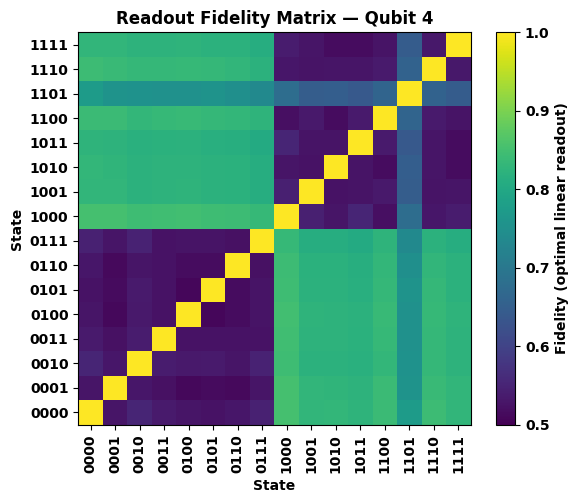

Hardest pair for qubit 4 : ('0100', '0101') F = 0.5095000000000001


In [97]:
X, y = load_dataset()
qubit_index = 3   # e.g. qubit4

states, F_mat = build_fidelity_matrix_for_qubit(X, y, qubit_index)
plot_fidelity_heatmap(states, F_mat, qubit_index)

# hardest pair = lowest fidelity (but > 0.5)
n = len(states)
min_F = 1.0
min_pair = None
for i in range(n):
    for j in range(i+1, n):
        if 0.5 <= F_mat[i,j] < min_F:
            min_F = F_mat[i,j]
            min_pair = (states[i], states[j])

print("Hardest pair for qubit", qubit_index+1, ":", min_pair, "F =", min_F)


## SVM Approach


=== SVM results for Qubit 1 ===
Accuracy: 0.7157
Confusion Matrix:
[[1723  277]
 [ 860 1140]]


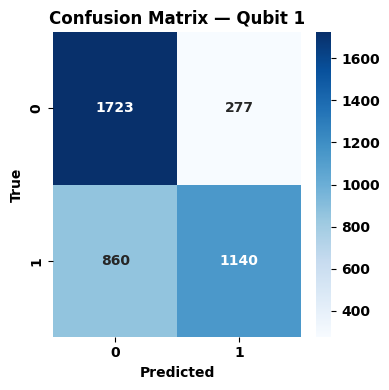

In [98]:
"""
Phase 1: Train an SVM model to predict a single qubit state (0 or 1)
based on 8 real-valued IQ features extracted from 4 complex qubit readouts.
The script loads dataset_X.txt and dataset_y.txt, selects one qubit label,
trains an SVM classifier, evaluates accuracy, and prints confusion matrix.
"""
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# Load dataset
# -------------------------------------------------------------
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    """
    Load X (complex values) and y (bit labels).
    X has shape (16000,4) with complex entries.
    y has shape (16000,4) with 0/1 entries.
    """
    X = np.loadtxt(X_path, dtype=complex)
    y = np.loadtxt(y_path, dtype=int)
    return X, y

# -------------------------------------------------------------
# Convert 4 complex inputs into 8 real-valued features
# -------------------------------------------------------------
def complex_to_features(X_complex):
    """
    Convert X complex array (N,4) into real-valued features of size (N,8):
    [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4].
    """
    X_real = np.hstack([X_complex.real, X_complex.imag])
    return X_real

# -------------------------------------------------------------
# Train and evaluate SVM for a single qubit index
# -------------------------------------------------------------
def train_svm_for_qubit(qubit_index=0):
    """
    qubit_index: 0..3  (Qubit1..Qubit4)
    Trains an SVM to predict y[:, qubit_index].
    """
    # Load data
    X_complex, y_bits = load_dataset()

    # Convert complex data into 8 real features
    X = complex_to_features(X_complex)

    # Select one qubit label to predict
    y = y_bits[:, qubit_index]

    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # Create SVM classifier (RBF kernel initially)
    svm = SVC(kernel="rbf", C=1.0, gamma="scale")

    # Train model
    svm.fit(X_train, y_train)

    # Predict on test set
    y_pred = svm.predict(X_test)

    # Compute accuracy
    acc = accuracy_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== SVM results for Qubit {qubit_index+1} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1"],
                yticklabels=["0","1"])
    plt.title(f"Confusion Matrix — Qubit {qubit_index+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return svm, acc, cm

# -------------------------------------------------------------
# Run Phase 1 for one qubit (example: Qubit 1)
# -------------------------------------------------------------
if __name__ == "__main__":
    model, accuracy, cm = train_svm_for_qubit(qubit_index=0)



=== SVM results for Qubit 1 ===
Accuracy: 0.7157
Confusion Matrix:
[[1723  277]
 [ 860 1140]]


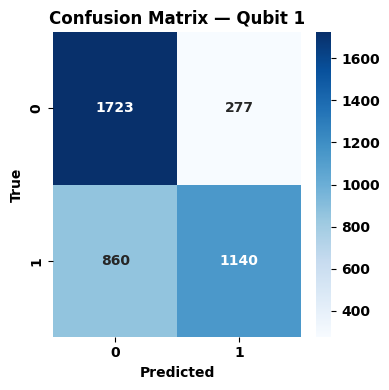


=== SVM results for Qubit 2 ===
Accuracy: 0.8190
Confusion Matrix:
[[1807  193]
 [ 531 1469]]


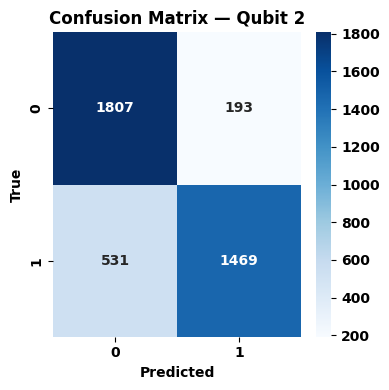


=== SVM results for Qubit 3 ===
Accuracy: 0.7977
Confusion Matrix:
[[1823  177]
 [ 632 1368]]


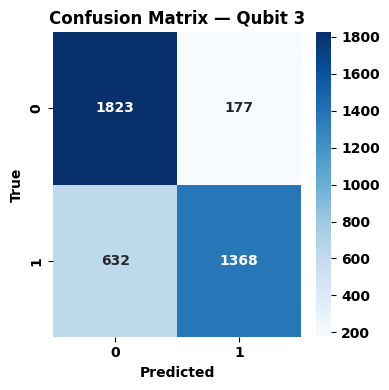


=== SVM results for Qubit 4 ===
Accuracy: 0.8190
Confusion Matrix:
[[1827  173]
 [ 551 1449]]


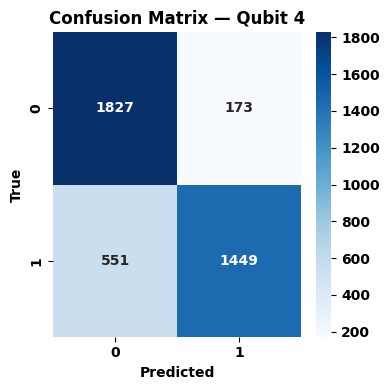

In [101]:
#excute phase 1 for qubit 2,3,4 as well
model_q1, acc_q1, cm_q1 = train_svm_for_qubit(qubit_index=0)
model_q2, acc_q2, cm_q2 = train_svm_for_qubit(qubit_index=1)
model_q3, acc_q3, cm_q3 = train_svm_for_qubit(qubit_index=2)
model_q4, acc_q4, cm_q4 = train_svm_for_qubit(qubit_index=3)

In [102]:
## plot the output with different method
"""
Visualization of SVM results for all 4 qubits:
- Bar chart of accuracies
- 2×2 grid of normalized confusion matrices
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_qubit_results(accuracies, confusion_matrices):
    """
    accuracies: list of 4 floats
    confusion_matrices: list of 4 (2×2) numpy arrays
    """

    qubit_names = ["Qubit 1", "Qubit 2", "Qubit 3", "Qubit 4"]

    # -----------------------------
    # Plot accuracy bar chart
    # -----------------------------
    plt.figure(figsize=(7,4))
    
    bars = plt.bar(qubit_names, accuracies, color=["#4c72b0", "#55a868", "#c44e52", "#8172b3"])
    plt.ylim(0,1)
    plt.ylabel("Accuracy")
    plt.title("SVM Classification Accuracy per Qubit")

    # label accuracy on top of bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 0.02, f"{acc:.3f}", 
                 ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot confusion matrices (normalized)
    # -----------------------------
    # fig, axes = plt.subplots(2, 2, figsize=(10,9))

    # for i, ax in enumerate(axes.flat):
    #     cm = confusion_matrices[i]
    #     cm_norm = cm / cm.sum(axis=1, keepdims=True)

    #     sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
    #                 xticklabels=["Pred 0", "Pred 1"],
    #                 yticklabels=["True 0", "True 1"],
    #                 ax=ax)

    #     ax.set_title(f"{qubit_names[i]} — Normalized Confusion Matrix")

    # plt.tight_layout()
    # plt.show()

    # -----------------------------
    # Print a summary
    # -----------------------------
    print("\n=== Summary of SVM Results ===")
    for i in range(4):
        print(f"{qubit_names[i]}: Accuracy = {accuracies[i]:.4f}")


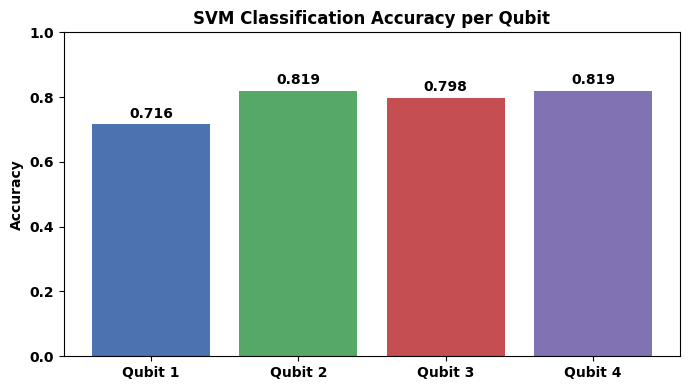


=== Summary of SVM Results ===
Qubit 1: Accuracy = 0.7157
Qubit 2: Accuracy = 0.8190
Qubit 3: Accuracy = 0.7977
Qubit 4: Accuracy = 0.8190


In [103]:
accuracies = [acc_q1, acc_q2, acc_q3, acc_q4]
confusion_matrices = [cm_q1, cm_q2, cm_q3, cm_q4]

plot_qubit_results(accuracies, confusion_matrices)


In [104]:
"""
Phase 3: Train a multi-class SVM (One-vs-Rest) to predict the full 4-qubit state.
Input features: 8 real-valued features extracted from 4 complex IQ measurements.
Output class: integer in {0,...,15}, representing the 4-bit qubit register.

This script:
1. Loads dataset_X.txt and dataset_y.txt
2. Converts 4 complex features → 8 real-valued features
3. Encodes 4-bit labels as integers 0..15
4. Trains an SVM multi-class classifier
5. Evaluates accuracy and prints confusion matrix
"""

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# -------------------------------------------------------------
# Load dataset
# -------------------------------------------------------------
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    X = np.loadtxt(X_path, dtype=complex)
    y = np.loadtxt(y_path, dtype=int)
    return X, y


# -------------------------------------------------------------
# Convert complex (N,4) into real-valued (N,8)
# -------------------------------------------------------------
# def complex_to_features(X_complex):
#     return np.hstack([X_complex.real, X_complex.imag])
def preprocess_features(X, method):
    """
    Preprocess real-valued features using different scaling methods.
    Parameters
    ----------
    X : ndarray, shape (N, d)
        Input feature matrix (real-valued)
    method : str
        'standard' -> StandardScaler
        'robust'   -> RobustScaler

    Returns
    -------
    X_scaled : ndarray
        Scaled features
    scaler : fitted scaler object
    """
    if method == "standard":
        scaler = StandardScaler()
    elif method == "robust":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def encode_features(X_complex, encoding):
    """
    Encode complex qubit readout data into real-valued features.

    Parameters
    ----------
    X_complex : ndarray, shape (N,4)
        Complex-valued qubit readouts
    encoding : str
        'iq'    -> [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]
        'angle' -> [|z1|, arg(z1), ..., |z4|, arg(z4)]

    Returns
    -------
    X_real : ndarray, shape (N,8)
        Real-valued feature matrix
    """
    if encoding == "iq":
        X_real = np.hstack([X_complex.real, X_complex.imag])

    elif encoding == "angle":
        amplitude = np.abs(X_complex)
        phase = np.angle(X_complex)   # range [-pi, pi]
        X_real = np.hstack([amplitude, phase])

    else:
        raise ValueError(f"Unknown encoding method: {encoding}")

    return X_real
# -------------------------------------------------------------
# Convert y (16000×4 bits) → integer label 0..15
# -------------------------------------------------------------
def bits_to_int_labels(y_bits):
    """
    Convert each 4-bit vector [q1,q2,q3,q4] into an integer in [0..15].
    Note: q1 = LSB, q4 = MSB.
    """
    q1 = y_bits[:, 0]
    q2 = y_bits[:, 1]
    q3 = y_bits[:, 2]
    q4 = y_bits[:, 3]

    labels = q1 + 2*q2 + 4*q3 + 8*q4
    return labels.astype(int)

# -------------------------------------------------------------
# Train multi-class SVM
# -------------------------------------------------------------
def train_multiclass_svm(encoding, preprocessing):
    # Load dataset
    X_complex, y_bits = load_dataset()

    # Convert to features
    # X = complex_to_features(X_complex)
    X_real = encode_features(X_complex, encoding=encoding)

    X_scaled, scaler = preprocess_features(X_real, method=preprocessing)

    # Encode 4-bit labels into class index 0..15
    y = bits_to_int_labels(y_bits)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_real, y, test_size=0.25, random_state=42, stratify=y
    )

    # Multi-class SVM (One-vs-Rest)
    svm = SVC(kernel="rbf", C=2.0, gamma="scale", decision_function_shape="ovr")
    svm.fit(X_train, y_train)

    # Predictions
    y_pred = svm.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== Multi-class SVM (16-state) ===")
    print(f"Accuracy: {acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=False, cmap="viridis")
    plt.title("Confusion Matrix — 16-class SVM")
    plt.xlabel("Predicted State")
    plt.ylabel("True State")
    plt.tight_layout()
    plt.show()

    return svm, acc, cm

# -------------------------------------------------------------
# Run Phase 3
# -------------------------------------------------------------
# if __name__ == "__main__":
#     model_mc, accuracy_mc, cm_mc = train_multiclass_svm()



=== Multi-class SVM (16-state) ===
Accuracy: 0.3890


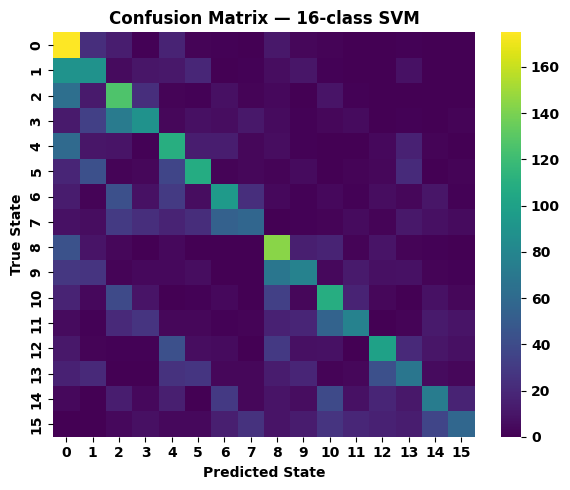

In [105]:
model_mc, accuracy_mc, cm_mc = train_multiclass_svm(
    preprocessing="standard",   # "robust" or "standard"
    encoding="iq"          # 'iq' or 'angle'
)


In [107]:
### optimizing Current SVM model: feature scaling and hyperparameter tuning
"""
Phase 3 — Improved multi-class SVM:
Includes:
1) Feature Scaling (StandardScaler)
2) Grid Search for best SVM hyperparameters
3) Confusion matrix visualization

This model predicts the 4-bit state as a single multi-class label (0..15).
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# -------------------------------------------------------------
# Load dataset
# -------------------------------------------------------------
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    X = np.loadtxt(X_path, dtype=complex)
    y = np.loadtxt(y_path, dtype=int)
    return X, y

# -------------------------------------------------------------
# Convert (N,4) complex → (N,8) real
# -------------------------------------------------------------
def complex_to_features(X_complex):
    return np.hstack([X_complex.real, X_complex.imag])

# -------------------------------------------------------------
# Convert 4 bits → integer label 0..15
# -------------------------------------------------------------
def bits_to_int_labels(y_bits):
    q1 = y_bits[:, 0]
    q2 = y_bits[:, 1]
    q3 = y_bits[:, 2]
    q4 = y_bits[:, 3]
    return (q1 + 2*q2 + 4*q3 + 8*q4).astype(int)

# -------------------------------------------------------------
# Train improved SVM with scaling + grid search
# -------------------------------------------------------------
def train_improved_svm():
    # Load data
    X_complex, y_bits = load_dataset()
    X = complex_to_features(X_complex)
    y = bits_to_int_labels(y_bits)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # -----------------------------------
    # Pipeline: Scaling + SVM
    # -----------------------------------
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(decision_function_shape="ovr"))
    ])

    # -----------------------------------
    # Grid Search parameters
    # -----------------------------------
    param_grid = {
        "svm__kernel": ["rbf", "poly"],
        "svm__C": [0.5, 1],
        "svm__gamma": ["scale", 0.1, 0.05, 0.01],
        "svm__degree": [2, 3],   # Only used for poly kernel
    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    print("\n🔍 Running Grid Search... Please wait.\n")
    grid.fit(X_train, y_train)

    print("\n=== Best Parameters Found ===")
    print(grid.best_params_)

    best_model = grid.best_estimator_

    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== Improved Multi-class SVM ===")
    print(f"Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, cmap="viridis", annot=False)
    plt.title("Confusion Matrix — Improved 16-class SVM")
    plt.xlabel("Predicted State")
    plt.ylabel("True State")
    plt.tight_layout()
    plt.show()

    return best_model, acc, cm, grid.best_params_

# -------------------------------------------------------------
# Run Phase 3 Improved SVM
# -------------------------------------------------------------
# if __name__ == "__main__":
#     best_model, acc, cm, best_params = train_improved_svm()


In [ ]:
# best_model, acc, cm, best_params = train_improved_svm()

In [108]:
"""
Phase 3: Multi-class classification using an MLP neural network.
The model predicts the full 4-qubit state (0..15) from 8 real-valued IQ features.

Pipeline:
1. Load X (complex) and y (4-bit labels).
2. Convert complex → 8 real features.
3. Convert 4-bit labels → integer 0..15.
4. Split train/test.
5. Build an MLP model: 8 → 32 → 16 → Softmax.
6. Train with Adam optimizer.
7. Evaluate accuracy and plot confusion matrix.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models


# -------------------------------------------------------------
# Load dataset
# -------------------------------------------------------------
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    X = np.loadtxt(X_path, dtype=complex)
    y = np.loadtxt(y_path, dtype=int)
    return X, y


# -------------------------------------------------------------
# Convert complex (N,4) -> real-valued (N,8)
# -------------------------------------------------------------
# def complex_to_features(X_complex):
#     return np.hstack([X_complex.real, X_complex.imag])

def preprocess_features(X, preprocessing):
    """
    Preprocess real-valued features using different scaling methods.
    Parameters
    ----------
    X : ndarray, shape (N, d)
        Input feature matrix (real-valued)
    method : str
        'standard' -> StandardScaler
        'robust'   -> RobustScaler

    Returns
    -------
    X_scaled : ndarray
        Scaled features
    scaler : fitted scaler object
    """
    if preprocessing == "standard":
        scaler = StandardScaler()
    elif preprocessing == "robust":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown preprocessing method: {preprocessing}")

    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def encode_features(X_complex, encoding):
    """
    Encode complex qubit readout data into real-valued features.

    Parameters
    ----------
    X_complex : ndarray, shape (N,4)
        Complex-valued qubit readouts
    encoding : str
        'iq'    -> [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]
        'angle' -> [|z1|, arg(z1), ..., |z4|, arg(z4)]

    Returns
    -------
    X_real : ndarray, shape (N,8)
        Real-valued feature matrix
    """
    if encoding == "iq":
        X_real = np.hstack([X_complex.real, X_complex.imag])

    elif encoding == "angle":
        amplitude = np.abs(X_complex)
        phase = np.angle(X_complex)   # range [-pi, pi]
        X_real = np.hstack([amplitude, phase])

    else:
        raise ValueError(f"Unknown encoding method: {encoding}")

    return X_real
# -------------------------------------------------------------
# Convert 4 bits -> integer 0..15
# -------------------------------------------------------------
def bits_to_int_labels(y_bits):
    q1 = y_bits[:, 0]
    q2 = y_bits[:, 1]
    q3 = y_bits[:, 2]
    q4 = y_bits[:, 3]
    return (q1 + 2*q2 + 4*q3 + 8*q4).astype(int)


# -------------------------------------------------------------
# Build MLP model
# -------------------------------------------------------------
def build_mlp(input_dim=8, num_classes=16):
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(input_dim,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# -------------------------------------------------------------
# Train + evaluate MLP
# -------------------------------------------------------------
def train_mlp_model(preprocessing, encoding):
    # Load data
    X_complex, y_bits = load_dataset()

    # Feature conversion
    # X = complex_to_features(X_complex)
    X_real = encode_features(X_complex, encoding=encoding)

    y = bits_to_int_labels(y_bits)

    X_scaled, scaler = preprocess_features(X_real, preprocessing=preprocessing)
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_real, y, test_size=0.25, random_state=42, stratify=y
    )

    # Feature scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # Build MLP
    model = build_mlp()

    print("\n🔧 Training MLP model...\n")

    # Train
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=51,
        batch_size=64,
        verbose=1
    )

    # Predict on test set
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print("\n=== MLP Multi-class Classification ===")
    print(f"Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, cmap="viridis", annot=False)
    plt.title("Confusion Matrix — MLP (16-class)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return model, acc, cm, history


# -------------------------------------------------------------
# Run Phase 3 — MLP
# -------------------------------------------------------------
# if __name__ == "__main__":
#     model, acc, cm, history = train_mlp_model()



🔧 Training MLP model...

Epoch 1/51


c:\Users\10\anaconda3\envs\qcomputing\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1739 - loss: 2.7736 - val_accuracy: 0.3288 - val_loss: 2.0970
Epoch 2/51
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3458 - loss: 2.0644 - val_accuracy: 0.3458 - val_loss: 2.0165
Epoch 3/51
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3532 - loss: 2.0353 - val_accuracy: 0.3558 - val_loss: 2.0010
Epoch 4/51
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3557 - loss: 2.0188 - val_accuracy: 0.3571 - val_loss: 2.0081
Epoch 5/51
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3579 - loss: 2.0074 - val_accuracy: 0.3642 - val_loss: 1.9885
Epoch 6/51
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3671 - loss: 1.9962 - val_accuracy: 0.3600 - val_loss: 1.9964
Epoch 7/51
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3666 - loss: 1.9910 - val_accuracy: 0.3654 - val_loss: 1.9844
Epoch 8/51
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3696 - loss: 1.9932 - val_accuracy: 0.3617 - val_

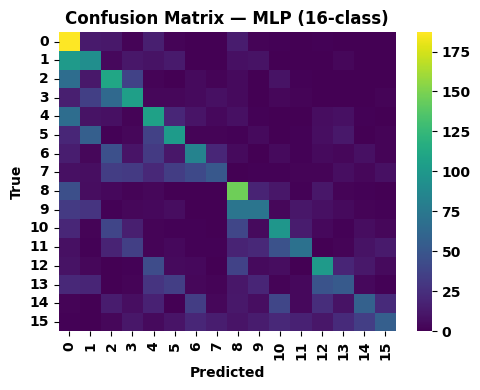

In [109]:
model, acc, cm, history = train_mlp_model(
    preprocessing="standard",   # "robust" or "standard"
    encoding="iq"               # 'iq' or 'angle'
    )

### NEW SVM approach with custom kernel function

In [110]:
"""
This script implements a custom ZZ feature-map inspired kernel for SVM.
It loads the user's dataset (complex readouts of 4 qubits), converts them
to 8 real-valued IQ features, defines a tunable ZZ kernel, and trains an SVM
to classify one qubit's state (0/1). The gamma parameters of the kernel 
can be easily modified for experimentation.

Dataset format:
    X: 16000 × 4   (complex values)      <-- loaded as dtype=complex
    y: 16000 × 4   (bit labels)
"""

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ================================================================
# 1) Load the dataset (fully compatible with your stored files)
# ================================================================
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    """
    Loads X as complex numbers (N,4) and labels y as integers (N,4).
    """
    X = np.loadtxt(X_path, dtype=complex)   # e.g. +1.23e-01+4.56e-01j
    y = np.loadtxt(y_path, dtype=int)
    return X, y

# ================================================================
# 2) Convert complex data → 8 real features
# ================================================================
def preprocess_features(X, method="standard"):
    """
    Preprocess real-valued features using different scaling methods.
    Parameters
    ----------
    X : ndarray, shape (N, d)
        Input feature matrix (real-valued)
    method : str
        'standard' -> StandardScaler
        'robust'   -> RobustScaler

    Returns
    -------
    X_scaled : ndarray
        Scaled features
    scaler : fitted scaler object
    """
    if method == "standard":
        scaler = StandardScaler()
    elif method == "robust":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

# def complex_to_features(X_complex):
#     """
#     Converts (N,4) complex array into (N,8) real feature matrix:
#         [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]
#     """
#     X_real = np.hstack([X_complex.real, X_complex.imag])
#     return X_real

def encode_features(X_complex, encoding="iq"):
    """
    Encode complex qubit readout data into real-valued features.

    Parameters
    ----------
    X_complex : ndarray, shape (N,4)
        Complex-valued qubit readouts
    encoding : str
        'iq'    -> [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]
        'angle' -> [|z1|, arg(z1), ..., |z4|, arg(z4)]

    Returns
    -------
    X_real : ndarray, shape (N,8)
        Real-valued feature matrix
    """
    if encoding == "iq":
        X_real = np.hstack([X_complex.real, X_complex.imag])

    elif encoding == "angle":
        amplitude = np.abs(X_complex)
        phase = np.angle(X_complex)   # range [-pi, pi]
        X_real = np.hstack([amplitude, phase])

    else:
        raise ValueError(f"Unknown encoding method: {encoding}")

    return X_real

# ================================================================
# 3) Build the ZZ kernel (fully tunable)
# ================================================================
def make_zz_kernel(gamma_single=1.0, gamma_pair=1.0):
    """
    Returns a kernel function suitable for sklearn SVC:
        K(x,y) = prod_k cos( gamma_single * (x_k - y_k) )
                 × prod_{i<j} cos( gamma_pair * (x_i x_j - y_i y_j) )

    Inputs must be real-valued feature matrices of shape (N,8).
    """

    def zz_kernel(X, Y=None):
        X = np.asarray(X, float)
        if Y is None:
            Y = X
        else:
            Y = np.asarray(Y, float)

        nX, d = X.shape
        nY = Y.shape[0]

        # --- Single-qubit terms ---
        diff = X[:, None, :] - Y[None, :, :]        # shape (nX, nY, d)
        K_single = np.cos(gamma_single * diff).prod(axis=2)  # (nX, nY)

        # --- Pairwise ZZ terms ---
        K_pair = np.ones_like(K_single)
        for i in range(d):
            for j in range(i + 1, d):
                uX = X[:, i] * X[:, j]
                uY = Y[:, i] * Y[:, j]
                diff_pair = uX[:, None] - uY[None, :]
                K_pair *= np.cos(gamma_pair * diff_pair)

        return K_single * K_pair

    return zz_kernel

# ================================================================
# 4) Train SVM for a selected qubit index using ZZ kernel
# ================================================================
def train_svm_with_zz_kernel(qubit_index=0,
                            gamma_single=0.5,
                            gamma_pair=0.1,
                            preprocessing="standard",
                            encoding ="iq"      # 'iq' or 'angle'
                            ):
    """
    Trains a binary classifier for qubit_index (0..3) using ZZ kernel.
    Allows tuning gamma_single and gamma_pair.
    """

    print(f"\nTraining SVM for qubit {qubit_index+1} using ZZ kernel...")

    # Load data
    X_complex, y_bits = load_dataset()

    # Encode features (IQ or Angle)
    X_real = encode_features(X_complex, encoding=encoding)
    y = y_bits[:, qubit_index]

    # Build kernel
    zz_kernel = make_zz_kernel(gamma_single=gamma_single,
                               gamma_pair=gamma_pair)

    # Use pipeline: scaling + SVM
    #------------------------------
    #------------------------------
# Preprocess features
    X_scaled, scaler = preprocess_features(X_real, method=preprocessing)

# Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # Train SVM (NO scaler inside pipeline anymore)
    model = SVC(kernel=zz_kernel, C=1.0)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy = {acc:.4f}")
    print("Confusion matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1"], yticklabels=["0","1"])
    plt.title(f"ZZ Kernel – Qubit {qubit_index+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return model, acc, cm



Training SVM for qubit 1 using ZZ kernel...
Accuracy = 0.7147
Confusion matrix:
 [[1685  315]
 [ 826 1174]]


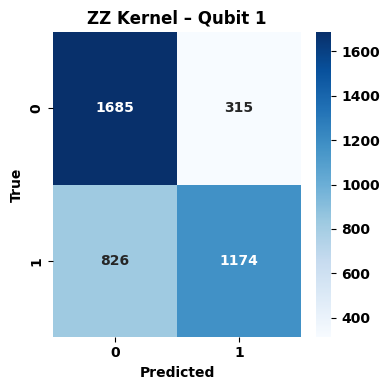

In [111]:
# 71.4
model, acc, cm = train_svm_with_zz_kernel(
    qubit_index=0,
    gamma_single=0.5,
    gamma_pair=0.1,
    preprocessing="robust",   # "robust" or "standard"
    encoding="angle"          # 'iq' or 'angle'
)

In [112]:
### Find the best gamma parameters via grid search

def grid_search_zz_kernel(
    qubit_index,
    gamma_single_list=[0.2, 0.5, 0.8, 1.0],
    gamma_pair_list=[0.1, 0.3, 0.5, 1.0]
):
    """
    Runs a manual grid search over gamma_single and gamma_pair.
    Returns a list of results and the best parameter set.
    """

    # Load dataset once (avoid repeating)
    X_complex, y_bits = load_dataset()
    X_real = encode_features(X_complex, encoding=encoding)
    y = y_bits[:, qubit_index]

    # Split train/test once (consistent comparisons)
    X_train, X_test, y_train, y_test = train_test_split(
        X_real, y, test_size=0.25, random_state=42, stratify=y
    )

    results = []
    best_acc = -1
    best_params = None

    print("\n===== GRID SEARCH START =====\n")
    for gs in gamma_single_list:
        for gp in gamma_pair_list:
            print(f"Testing gamma_single={gs}, gamma_pair={gp}")

            # Build kernel for this pair
            zz_kernel = make_zz_kernel(gamma_single=gs, gamma_pair=gp)

            # Build model
            model = Pipeline([
                ("scaler", StandardScaler()),
                ("svm", SVC(kernel=zz_kernel, C=1.0))
            ])

            # Train
            model.fit(X_train, y_train)

            # Predict & accuracy
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            print(f"  → Accuracy = {acc:.4f}")

            # Save result
            results.append((gs, gp, acc))

            # Track best
            if acc > best_acc:
                best_acc = acc
                best_params = (gs, gp)

    print("\n===== GRID SEARCH FINISHED =====")
    print(f"Best accuracy = {best_acc:.4f} with parameters:")
    print(f"gamma_single = {best_params[0]}")
    print(f"gamma_pair   = {best_params[1]}")

    return results, best_params



In [ ]:
# results, best = grid_search_zz_kernel(qubit_index=0)


===== GRID SEARCH START =====

Testing gamma_single=0.2, gamma_pair=0.1
  → Accuracy = 0.7125
Testing gamma_single=0.2, gamma_pair=0.3
  → Accuracy = 0.6990
Testing gamma_single=0.2, gamma_pair=0.5
  → Accuracy = 0.6705
Testing gamma_single=0.2, gamma_pair=0.8
  → Accuracy = 0.6005
Testing gamma_single=0.2, gamma_pair=1.0
  → Accuracy = 0.5600
Testing gamma_single=0.5, gamma_pair=0.1
  → Accuracy = 0.7153
Testing gamma_single=0.5, gamma_pair=0.3
  → Accuracy = 0.7065
Testing gamma_single=0.5, gamma_pair=0.5
  → Accuracy = 0.6783
Testing gamma_single=0.5, gamma_pair=0.8
  → Accuracy = 0.6255
Testing gamma_single=0.5, gamma_pair=1.0
  → Accuracy = 0.5870
Testing gamma_single=0.8, gamma_pair=0.1
  → Accuracy = 0.6947
Testing gamma_single=0.8, gamma_pair=0.3
  → Accuracy = 0.6995
Testing gamma_single=0.8, gamma_pair=0.5
  → Accuracy = 0.6710
Testing gamma_single=0.8, gamma_pair=0.8
  → Accuracy = 0.6258
Testing gamma_single=0.8, gamma_pair=1.0
  → Accuracy = 0.5873
Testing gamma_single=1.

### SVM classifier for 16 classes


In [113]:
"""
Train a multi-class SVM (One-vs-Rest) to predict the full 4-qubit state
using a custom ZZ feature-map inspired kernel.

Input:
    - dataset_X.txt : (N,4) complex IQ readouts for 4 qubits
    - dataset_y.txt : (N,4) bit labels [q1,q2,q3,q4]

Features:
    - Each complex readout (4) is converted to 8 real-valued features:
      [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]

Labels:
    - 4-bit vectors [q1,q2,q3,q4] are encoded as integers 0..15
      where q1 is LSB and q4 is MSB.

Model:
    - SVM with a custom ZZ kernel K(x,y), parameterized by
      gamma_single and gamma_pair.
"""

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# Load dataset
# -------------------------------------------------------------
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    """
    Load X as complex (N,4) and y as int (N,4).
    """
    X = np.loadtxt(X_path, dtype=complex)
    y = np.loadtxt(y_path, dtype=int)
    return X, y

# -------------------------------------------------------------
# Convert complex (N,4) into real-valued (N,8)
# -------------------------------------------------------------
# def complex_to_features(X_complex):
#     """
#     Convert 4 complex features → 8 real-valued IQ features:
#         [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]
#     """
#     return np.hstack([X_complex.real, X_complex.imag])
def preprocess_features(X, preprocessing):
    """
    Preprocess real-valued features using different scaling methods.
    Parameters
    ----------
    X : ndarray, shape (N, d)
        Input feature matrix (real-valued)
    method : str
        'standard' -> StandardScaler
        'robust'   -> RobustScaler

    Returns
    -------
    X_scaled : ndarray
        Scaled features
    scaler : fitted scaler object
    """
    if preprocessing == "standard":
        scaler = StandardScaler()
    elif preprocessing == "robust":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown preprocessing method: {preprocessing}")

    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler


#-------------------------------------------------------------
#-------------------------------------------------------------
def encode_features(X_complex, encoding):
    """
    Encode complex qubit readout data into real-valued features.

    Parameters
    ----------
    X_complex : ndarray, shape (N,4)
        Complex-valued qubit readouts
    encoding : str
        'iq'    -> [Re1, Im1, Re2, Im2, Re3, Im3, Re4, Im4]
        'angle' -> [|z1|, arg(z1), ..., |z4|, arg(z4)]

    Returns
    -------
    X_real : ndarray, shape (N,8)
        Real-valued feature matrix
    """
    if encoding == "iq":
        X_real = np.hstack([X_complex.real, X_complex.imag])

    elif encoding == "angle":
        amplitude = np.abs(X_complex)
        phase = np.angle(X_complex)   # range [-pi, pi]
        X_real = np.hstack([amplitude, phase])

    else:
        raise ValueError(f"Unknown encoding method: {encoding}")

    return X_real


# -------------------------------------------------------------
# Convert y (N×4 bits) → integer labels 0..15
# -------------------------------------------------------------
def bits_to_int_labels(y_bits):
    """
    Convert each 4-bit vector [q1,q2,q3,q4] into an integer in [0..15].
    Convention: q1 is LSB, q4 is MSB.

        label = q1 + 2*q2 + 4*q3 + 8*q4
    """
    q1 = y_bits[:, 0]
    q2 = y_bits[:, 1]
    q3 = y_bits[:, 2]
    q4 = y_bits[:, 3]

    labels = q1 + 2*q2 + 4*q3 + 8*q4
    return labels.astype(int)


# -------------------------------------------------------------
# ZZ kernel factory
# -------------------------------------------------------------
def make_zz_kernel(gamma_single=1.0, gamma_pair=1.0):
    """
    Build a ZZ-inspired kernel function suitable for sklearn SVC.

    K(x,y) = Π_k cos( gamma_single * (x_k - y_k) )
             × Π_{i<j} cos( gamma_pair * (x_i x_j - y_i y_j) )

    Inputs X, Y must be real-valued matrices of shape (N,d).
    Here d = 8 (8 IQ features).
    """
    def zz_kernel(X, Y=None):
        X = np.asarray(X, float)
        if Y is None:
            Y = X
        else:
            Y = np.asarray(Y, float)

        nX, d = X.shape
        nY = Y.shape[0]

        # --- Single-feature terms ---
        diff = X[:, None, :] - Y[None, :, :]     # shape (nX, nY, d)
        K_single = np.cos(gamma_single * diff).prod(axis=2)  # (nX, nY)

        # --- Pairwise ZZ interaction terms ---
        K_pair = np.ones_like(K_single)
        for i in range(d):
            for j in range(i + 1, d):
                uX = X[:, i] * X[:, j]          # (nX,)
                uY = Y[:, i] * Y[:, j]          # (nY,)
                diff_pair = uX[:, None] - uY[None, :]
                K_pair *= np.cos(gamma_pair * diff_pair)

        return K_single * K_pair

    return zz_kernel


# -------------------------------------------------------------
# Train multi-class SVM with ZZ kernel
# -------------------------------------------------------------
def train_multiclass_svm_zz(
    gamma_single,
    gamma_pair,
    C,
    preprocessing,   #  "standard" or "robust"
    encoding        # 'iq' or 'angle'
):
    """
    Train a 16-class SVM to predict the full 4-qubit state using
    the ZZ-inspired kernel.

    Parameters:
        gamma_single : float  - coefficient for single-feature cos term
        gamma_pair   : float  - coefficient for pairwise ZZ cos term
        C            : float  - SVM regularization parameter
    """

    # 1) Load dataset
    X_complex, y_bits = load_dataset()

    # 2) # Encode complex → real features
    X_real = encode_features(X_complex, encoding=encoding)

    # Apply preprocessing
    X_scaled, scaler = preprocess_features(X_real, preprocessing)

    # 3) Encode 4-bit labels into class index 0..15
    y = bits_to_int_labels(y_bits)

    # 4) Split data into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # 5) Build ZZ kernel with given parameters
    zz_kernel = make_zz_kernel(
        gamma_single=gamma_single,
        gamma_pair=gamma_pair
    )

    # 6) Build model pipeline: scaling + SVM with custom kernel
    svm = SVC(
        kernel=zz_kernel,
        C=C,
        decision_function_shape="ovr"
    )
    
    svm.fit(X_train, y_train)
    # model = Pipeline([
    #     ("scaler", StandardScaler()),
    #     ("svm", svm)
    # ])

    # 7) Train
    print(f"\nTraining multi-class SVM with ZZ kernel:")
    print(f"  gamma_single = {gamma_single}")
    print(f"  gamma_pair   = {gamma_pair}")
    print(f"  C            = {C}")
    model.fit(X_train, y_train)

    # 8) Predict on test set
    y_pred = model.predict(X_test)

    # 9) Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== Multi-class SVM (16-state) with ZZ kernel ===")
    print(f"Accuracy: {acc:.4f}")

    # 10) Confusion matrix (16×16)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=False, cmap="viridis")
    plt.title("Confusion Matrix — 16-class ZZ-kernel SVM")
    plt.xlabel("Predicted State (0..15)")
    plt.ylabel("True State (0..15)")
    plt.tight_layout()
    plt.show()

    return model, acc, cm




Training multi-class SVM with ZZ kernel:
  gamma_single = 0.05
  gamma_pair   = 0.05
  C            = 1.0

=== Multi-class SVM (16-state) with ZZ kernel ===
Accuracy: 0.3867


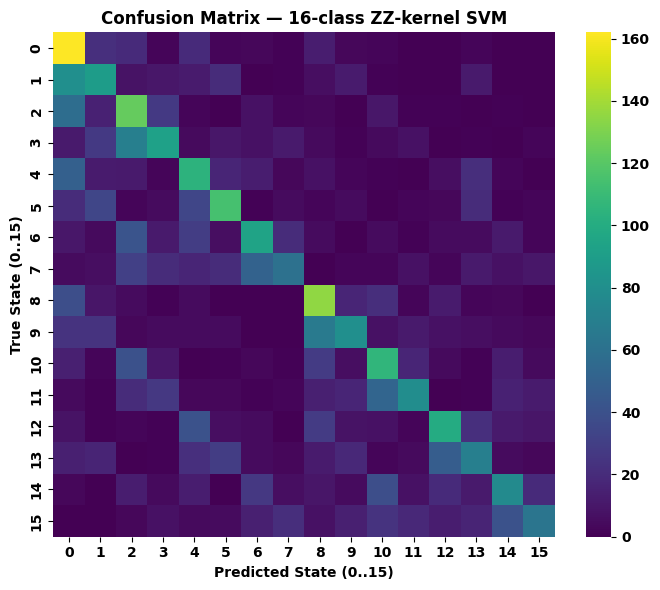

In [114]:

# Insert here the best gamma values you found for the full-state task,
# or start by reusing e.g. the ones from qubit 1 as a first guess.
model_mc, accuracy_mc, cm_mc = train_multiclass_svm_zz(
    gamma_single=0.05,
    gamma_pair=0.05,
    C=1.0,
    preprocessing="robust",    # or "standard"
    encoding="iq"              # 'iq' or 'angle'
    )


In [41]:
###   یافت بهترین پارامتها برای حالت 16 کلاس
## find the best gamma parameters via grid search for multi-class SVM with ZZ kernel
def grid_search_multiclass_zz(
    gamma_single_list=[0.1, 0.5],      # 
    gamma_pair_list=[0.1, 0.3],   # 
    C_list=[1.0],            # 1.0 is the best choice for C
    test_size=0.25,
    random_state=42
):
    """
    Perform a grid search for multi-class (16-state) SVM using the ZZ kernel.

    Parameters:
        gamma_single_list : list of floats
        gamma_pair_list   : list of floats
        C_list            : list of floats (SVM regularization parameter)

    Returns:
        results : list of tuples (gamma_single, gamma_pair, C, accuracy)
        best_params : (gs, gp, C)
    """

    print("\n===== MULTI-CLASS GRID SEARCH STARTED =====\n")

    # -------------------------------------------------------------
    # Load dataset once
    # -------------------------------------------------------------
    X_complex, y_bits = load_dataset()
    # X = complex_to_features(X_complex)
    X = encode_features(X_complex, encoding=encoding)
    y = bits_to_int_labels(y_bits)

    # -------------------------------------------------------------
    # Use ONE fixed train/test split for all runs
    # -------------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                         random_state=random_state, stratify=y)

    results = []
    best_acc = -1
    best_params = None

    # -------------------------------------------------------------
    # Grid search loops
    # -------------------------------------------------------------
    for gs in gamma_single_list:
        for gp in gamma_pair_list:
            for C_val in C_list:

                print(f"Testing gs={gs}, gp={gp}, C={C_val}")

                # Build ZZ kernel
                zz_kernel = make_zz_kernel(
                    gamma_single=gs,
                    gamma_pair=gp
                )

                # Build model
                model = Pipeline([
                    ("scaler", StandardScaler()),
                    ("svm", SVC(kernel=zz_kernel,
                                C=C_val,
                                decision_function_shape="ovr"))
                ])

                # Train
                model.fit(X_train, y_train)

                # Test
                y_pred = model.predict(X_test)
                acc = accuracy_score(y_test, y_pred)

                print(f"  → Acc = {acc:.4f}")

                # Store result
                results.append((gs, gp, C_val, acc))

                # Update best
                if acc > best_acc:
                    best_acc = acc
                    best_params = (gs, gp, C_val)

    print("\n===== GRID SEARCH FINISHED =====")
    print(f"Best accuracy: {best_acc:.4f}")
    print(f"Best parameters:")
    print(f"   gamma_single = {best_params[0]}")
    print(f"   gamma_pair   = {best_params[1]}")
    print(f"   C            = {best_params[2]}")

    return results, best_params


In [ ]:
# results, best_params = grid_search_multiclass_zz()
# print("\nBest parameters found:", best_params)


===== MULTI-CLASS GRID SEARCH STARTED =====

Testing gs=0.1, gp=0.1, C=1.0
  → Acc = 0.3897
Testing gs=0.1, gp=0.1, C=2.0
  → Acc = 0.3867
Testing gs=0.1, gp=0.1, C=5.0
  → Acc = 0.3820
Testing gs=0.1, gp=0.3, C=1.0
  → Acc = 0.3670
Testing gs=0.1, gp=0.3, C=2.0
  → Acc = 0.3530
Testing gs=0.1, gp=0.3, C=5.0
  → Acc = 0.3302
Testing gs=0.1, gp=1.0, C=1.0
  → Acc = 0.1353
Testing gs=0.1, gp=1.0, C=2.0
  → Acc = 0.1363
Testing gs=0.1, gp=1.0, C=5.0
  → Acc = 0.1343
Testing gs=0.5, gp=0.1, C=1.0
  → Acc = 0.3750
Testing gs=0.5, gp=0.1, C=2.0
  → Acc = 0.3735
Testing gs=0.5, gp=0.1, C=5.0
  → Acc = 0.3573
Testing gs=0.5, gp=0.3, C=1.0
  → Acc = 0.3683
Testing gs=0.5, gp=0.3, C=2.0
  → Acc = 0.3458
Testing gs=0.5, gp=0.3, C=5.0
  → Acc = 0.3105
Testing gs=0.5, gp=1.0, C=1.0
  → Acc = 0.1767
Testing gs=0.5, gp=1.0, C=2.0
  → Acc = 0.1725
Testing gs=0.5, gp=1.0, C=5.0
  → Acc = 0.1680
Testing gs=1.5, gp=0.1, C=1.0
  → Acc = 0.0698
Testing gs=1.5, gp=0.1, C=2.0
  → Acc = 0.0757
Testing gs=1.5


Training multi-class SVM with ZZ kernel:
  gamma_single = 0.05
  gamma_pair   = 0.01
  C            = 1.0

=== Multi-class SVM (16-state) with ZZ kernel ===
Accuracy: 0.3867


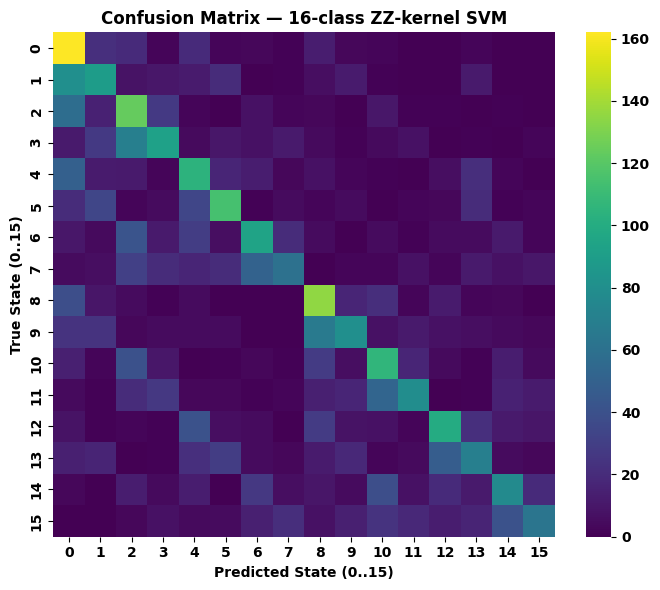

In [115]:
# Insert here the best gamma values you found for the full-state task,
# or start by reusing e.g. the ones from qubit 1 as a first guess.  38.67
model_mc, accuracy_mc, cm_mc = train_multiclass_svm_zz(
    gamma_single=0.05,
    gamma_pair=0.01,
    C=1.0,
    preprocessing="robust",    # or "standard"
    encoding="iq"              # 'iq' or 'angle'
    )